In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

#Get the ISO-Codes
iso = pd.read_csv("../Data/ISO/ISO.csv")

In [2]:
# --- : Load DataFrames from CSV ---
print("\nLoading W_ij Dataframes from CSV files...")
W_ij_dataframes = {}
csv_filenames = ['../Data/Networks/W_1_ij.csv', '../Data/Networks/W_2_ij.csv', '../Data/Networks/W_3_ij.csv']
for filename in csv_filenames:
    try:
        df_reloaded = pd.read_csv(filename)
        base_name = os.path.basename(filename) # Gets 'W_1_ij.csv'
        parts = base_name.split('_') # Splits into ['W', '1', 'ij.csv']
        
        # Check if the parts list has at least 2 elements and the second part is a number
        if len(parts) >= 2 and parts[1].isdigit():
            df_number = parts[1]
            new_df_name = f"W_{df_number}_ij"
        else:
            # Fallback if filename format is unexpected, or use the full name as before
            new_df_name = os.path.splitext(base_name)[0] 
            
        W_ij_dataframes[new_df_name] = df_reloaded
        print(f"Loaded {filename} as {new_df_name}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")


Loading W_ij Dataframes from CSV files...
Loaded ../Data/Networks/W_1_ij.csv as W_1_ij
Loaded ../Data/Networks/W_2_ij.csv as W_2_ij
Loaded ../Data/Networks/W_3_ij.csv as W_3_ij


In [3]:
# Define the desired start and end periods for filtering
start_period = 1989 
end_period = 2020  

print(f"\nFiltering DataFrames for periods between {start_period} and {end_period}...")
# Iterate through the dictionary and filter dataframes in-place
for df_name, df_content in W_ij_dataframes.items():
    if not df_content.empty and 'period' in df_content.columns:
        # Apply the period filter directly to the DataFrame in the dictionary
        original_rows = len(df_content)
        W_ij_dataframes[df_name] = df_content[(df_content['period'] >= start_period) & (df_content['period'] <= end_period)]
        print(f"Filtered {df_name}. Original rows: {original_rows}, Filtered rows: {len(W_ij_dataframes[df_name])}")
    else:
        print(f"Skipping filtering for {df_name}: DataFrame is empty or 'period' column is missing.")



Filtering DataFrames for periods between 1989 and 2020...
Filtered W_1_ij. Original rows: 81353, Filtered rows: 69127
Filtered W_2_ij. Original rows: 34585, Filtered rows: 29382
Filtered W_3_ij. Original rows: 94775, Filtered rows: 78649


In [4]:
# --- 1. PageRank Calculation for a Single Period ---
def calculate_pagerank(TN_t_c):
    """Calculates PageRank for a given period's DataFrame slice."""
    edges = TN_t_c[['reporterISO', 'partnerISO', 'W_ij']]

    countries = sorted(list(set(edges['reporterISO']).union(edges['partnerISO'])))
    country_index = {country: i for i, country in enumerate(countries)}
    n = len(countries)

    if n == 0:
        return pd.DataFrame(columns=['Country', 'PageRank']) # Return empty if no nodes

    W = np.zeros((n, n))
    for index, row in edges.iterrows():
        i = country_index[row['reporterISO']]
        j = country_index[row['partnerISO']]
        W[i, j] += row['W_ij']

    row_sums = W.sum(axis=1)
    dangling_nodes_mask = (row_sums == 0)

    M_row_stochastic = np.divide(W, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)
    if np.sum(dangling_nodes_mask) > 0:
        M_row_stochastic[dangling_nodes_mask, :] = 1.0 / n

    P = M_row_stochastic.T # Column-stochastic matrix for PageRank

    alpha = 0.85
    v = np.ones(n) / n
    r = np.ones(n) / n
    epsilon = 1e-8
    delta = 1.0
    iteration = 0
    max_iterations = 1000

    while delta > epsilon and iteration < max_iterations:
        r_new = alpha * P @ r + (1 - alpha) * v
        delta = np.linalg.norm(r_new - r, 1)
        r = r_new
        iteration += 1
    
    pagerank_t_c = pd.DataFrame({
        'Country': countries,
        'PageRank': r
    }).sort_values(by='PageRank', ascending=False).reset_index(drop=True)
    
    return pagerank_t_c

In [5]:
def calculate_pagerank_centrality_for_iso(df, iso_code):
    yearly_centrality = []
    
    # Check if the country exists in the dataset at all.
    if iso_code not in df['reporterISO'].unique() and iso_code not in df['partnerISO'].unique():
        return pd.DataFrame([{'period': year, 'pagerank_centrality': 0} for year in df['period'].unique()])

    for year, group in df.groupby('period'):
        # Calculate PageRank for the current year using the helper function
        pagerank_df = calculate_pagerank(group)
        
        # Find the PageRank centrality for the specified ISO code
        centrality_value = pagerank_df[pagerank_df['Country'] == iso_code]['PageRank'].iloc[0] if iso_code in pagerank_df['Country'].values else 0
        
        yearly_centrality.append({'period': year, 'pagerank_centrality': centrality_value})

    return pd.DataFrame(yearly_centrality)

In [6]:
df_centrality_W1 = calculate_pagerank_centrality_for_iso(W_ij_dataframes["W_1_ij"], 'CHN').rename(columns={'pagerank_centrality': 'W_1_ij'})
df_centrality_W2 = calculate_pagerank_centrality_for_iso(W_ij_dataframes["W_2_ij"], 'CHN').rename(columns={'pagerank_centrality': 'W_2_ij'})
df_centrality_W3 = calculate_pagerank_centrality_for_iso(W_ij_dataframes["W_3_ij"], 'CHN').rename(columns={'pagerank_centrality': 'W_3_ij'})

merged_df = (
    pd.merge(df_centrality_W1, df_centrality_W2, on='period', how='outer')
    .fillna(0)
    .merge(df_centrality_W3, on='period', how='outer')
    .fillna(0)
)


Saving plot to ../../Writing/Master/Figures/pagerank_centrality_matrix_CHN_plot.png with 300 DPI...
Plot saved successfully!


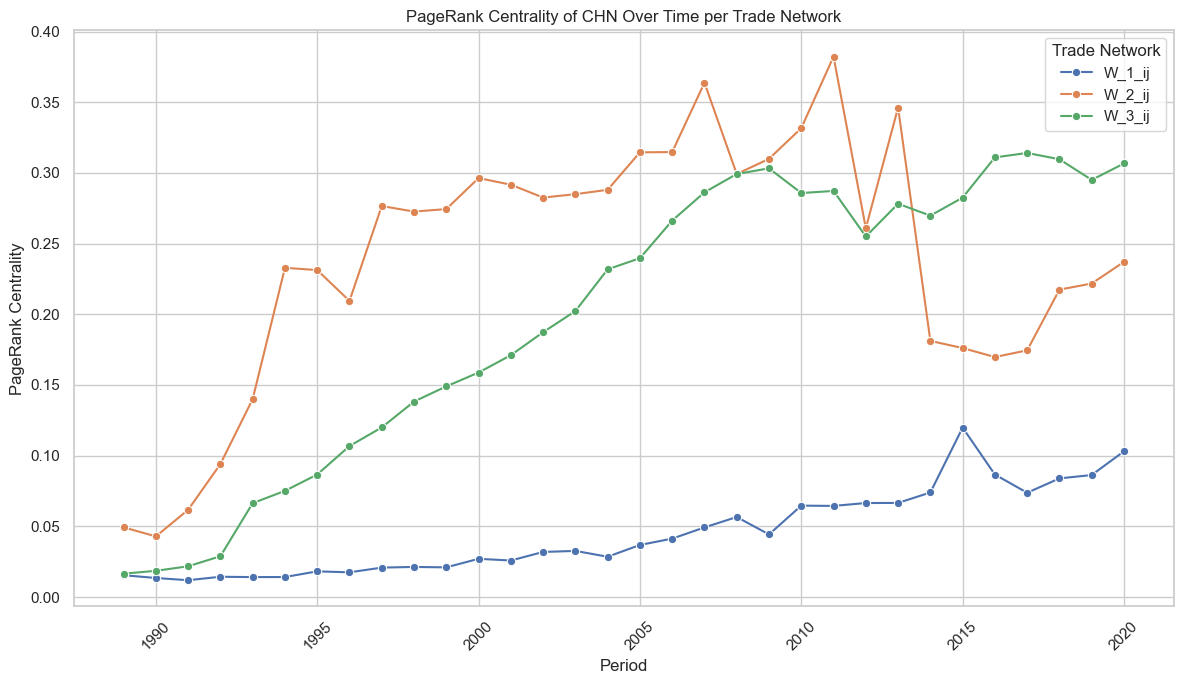

In [7]:
# Reshape the dataframe from wide to long format for Seaborn
long_format_df = pd.melt(merged_df, id_vars=['period'], var_name='DataFrame', value_name='pagerank_centrality')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=long_format_df,
    x='period',
    y='pagerank_centrality',
    hue='DataFrame',
    marker='o'
)

plt.xlabel('Period')
plt.ylabel('PageRank Centrality')
plt.title('PageRank Centrality of CHN Over Time per Trade Network')
plt.legend(title='Trade Network')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

output_filename = '../../Writing/Master/Figures/pagerank_centrality_matrix_CHN_plot.png'
output_dpi = 300

print(f"\nSaving plot to {output_filename} with {output_dpi} DPI...")
try:
    plt.savefig(output_filename, dpi=output_dpi, bbox_inches='tight')
    print("Plot saved successfully!")
except FileNotFoundError:
    print(f"Error: The directory for {output_filename} does not exist. Please create it.")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()

In [8]:
def calculate_pagerank_import(TN_t_c):
    """Calculates Import PageRank for a given period's DataFrame slice."""
    edges = TN_t_c[['reporterISO', 'partnerISO', 'W_ij']]

    countries = sorted(list(set(edges['reporterISO']).union(edges['partnerISO'])))
    country_index = {country: i for i, country in enumerate(countries)}
    n = len(countries)

    if n == 0:
        return pd.DataFrame(columns=['Country', 'PageRank']) # Return empty if no nodes

    W = np.zeros((n, n))
    for index, row in edges.iterrows():
        i = country_index[row['reporterISO']]
        j = country_index[row['partnerISO']]
        W[j, i] += row['W_ij'] # W_ij represents flow from reporterISO (i) to partnerISO (j)

    # Calculate row sums of W (sum of exports from each country)
    row_sums = W.sum(axis=1)
    
    # Identify dangling nodes (countries that don't export to anyone)
    dangling_nodes_mask = (row_sums == 0)

    # M_row_stochastic: M_ij = W_ij / sum(W_ik for k)
    # This represents the probability of a link from i to j (i.e., i exports to j)
    M_row_stochastic = np.divide(W, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)
    
    # Handle dangling nodes: If a row sums to zero, distribute its "score" equally.
    # This means a country with no exports distributes its importance to all others.
    if np.sum(dangling_nodes_mask) > 0:
        M_row_stochastic[dangling_nodes_mask, :] = 1.0 / n

    # For IMPORT PageRank, the transition matrix P should be the TRANSPOSE of M_row_stochastic.
    # If M_row_stochastic[i,j] is the probability i -> j, then M_row_stochastic.T[i,j] is the probability j -> i.
    # This makes P a column-stochastic matrix where P[i,j] represents the probability of moving from j to i.
    # The standard PageRank iteration r_new = alpha * P @ r works with a column-stochastic P.
    P = M_row_stochastic.T # Column-stochastic matrix for Import PageRank

    alpha = 0.85
    v = np.ones(n) / n # Personalization vector (uniform distribution)
    r = np.ones(n) / n # Initial PageRank vector
    epsilon = 1e-8 # Convergence threshold
    delta = 1.0 # Current difference between iterations
    iteration = 0
    max_iterations = 1000 # Maximum number of iterations to prevent infinite loops

    while delta > epsilon and iteration < max_iterations:
        r_new = alpha * P @ r + (1 - alpha) * v
        delta = np.linalg.norm(r_new - r, 1) # L1 norm for convergence check
        r = r_new
        iteration += 1
    
    pagerank_t_c = pd.DataFrame({
        'Country': countries,
        'PageRank': r
    }).sort_values(by='PageRank', ascending=False).reset_index(drop=True)
    
    return pagerank_t_c

# Example usage with your provided variable name:
# Assuming TN_t_c is defined somewhere, e.g., it's one of your loaded W_ij_dataframes
# For instance:
# TN_t_c = W_ij_dataframes
# 
['W_ij_2'] # Using W_ij_2 as an example
pagerank_2002_2_imports = calculate_pagerank_import(TN_t_c)
print(pagerank_2002_2_imports.head(10))


NameError: name 'TN_t_c' is not defined

In [ ]:
def calculate_pagerank(df: pd.DataFrame, reporter_col: str, partner_col: str, weight_col: str, damping_factor: float = 0.85, num_iterations: int = 100) -> pd.DataFrame:
    """
    Calculates PageRank scores for nodes in a graph represented by a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing the graph data.
        reporter_col (str): The name of the column representing the source nodes (e.g., 'reporterISO').
        partner_col (str): The name of the column representing the target nodes (e.g., 'partnerISO').
        weight_col (str): The name of the column representing the edge weights (e.g., 'W_ij').
        damping_factor (float, optional): The damping factor for the PageRank algorithm. Defaults to 0.85.
        num_iterations (int, optional): The maximum number of iterations for the PageRank calculation. Defaults to 100.

    Returns:
        pd.DataFrame: A DataFrame with 'Node' and 'PageRank' columns, sorted by PageRank in descending order.
    """

    # Ensure weight column is numeric
    df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')
    df.dropna(subset=[weight_col], inplace=True)

    # Get all unique nodes
    nodes = pd.Series(pd.concat([df[reporter_col], df[partner_col]])).unique()
    nodes.sort()
    num_nodes = len(nodes)

    # Create a mapping from node name to index
    node_to_index = {node: i for i, node in enumerate(nodes)}

    # Create an adjacency matrix
    adj_matrix = np.zeros((num_nodes, num_nodes))

    for _, row in df.iterrows():
        reporter_index = node_to_index[row[reporter_col]]
        partner_index = node_to_index[row[partner_col]]
        adj_matrix[reporter_index, partner_index] = row[weight_col]

    # Normalize the adjacency matrix to create a transition matrix
    out_degrees = np.sum(adj_matrix, axis=1)
    out_degrees[out_degrees == 0] = 1  # Avoid division by zero for dangling nodes
    transition_matrix = adj_matrix / out_degrees[:, np.newaxis]

    # Initial PageRank vector (uniform distribution)
    pagerank = np.ones(num_nodes) / num_nodes

    # Iterative PageRank calculation
    for _ in range(num_iterations):
        new_pagerank = (1 - damping_factor) / num_nodes + damping_factor * np.dot(transition_matrix.T, pagerank)
        if np.allclose(new_pagerank, pagerank):
            break
        pagerank = new_pagerank

    # Create a DataFrame for PageRank scores
    pagerank_df = pd.DataFrame({'Node': nodes, 'PageRank': pagerank})
    pagerank_df = pagerank_df.sort_values(by='PageRank', ascending=False).reset_index(drop=True)

    return pagerank_df